# Advanced Encoding: Using Model-Derived Representations of Naturalistic Stimuli to Encode Brain Data

The predictors formerly used to predict brain activations were limited.
They were manually-designed features and therefore, many dimensions of the input could not be taken into account.

For example, we could encode:


* perceptual features (is there a human in each frame? when watching a movie)
* the current word (when listening to a story)

BUT more complex information such as:

* the context in which these perceived objects usually occur,
* the probability distribution of the possible following words,
* etc...

cannot be easily encoded manually.

That's why we want to use tools that can build rich and complex representations of the stimuli.

This is where Machine Learning models arrive !


### Hypothesis:

If a given voxel is well predicted by the features derived from a machine learning model, this suggests that there is a high probability that the information encoded by this voxel and the information encoded by the model are similar.


### Downloading the required packages

In [ ]:
!pip install -r requirements.txt
!pip install -e .

### Downloading the encoding repository

In [ ]:
!git clone https://github.com/AlexandrePsq/main_tutorial.git

### Loading fMRI data and Stimuli

In [1]:
from src.data import load_fmri_data, load_stmuli, fetch_masker

stimuli_url = "https://drive.google.com/uc?id=1QsxmYaI-eOG7ip0Lfe82jXJ9-Ip3Oqxy&export=download"
fmri_url = "https://drive.google.com/uc?id=11HT-0TH0hOerOkP3zTDzkICqRt7s9ZQZ&export=download"

# Fetch fmri and stimuli data
fmri_data = load_fmri_data(fmri_url, download=False, template='./data/')
stimuli_data = load_stmuli(stimuli_url, download=False, template='./data/aligned')


/Applications/anaconda3/envs/parietal/lib/python3.7/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


We visualize the 6-th image of the first fMRI file (taken from fmri_data):

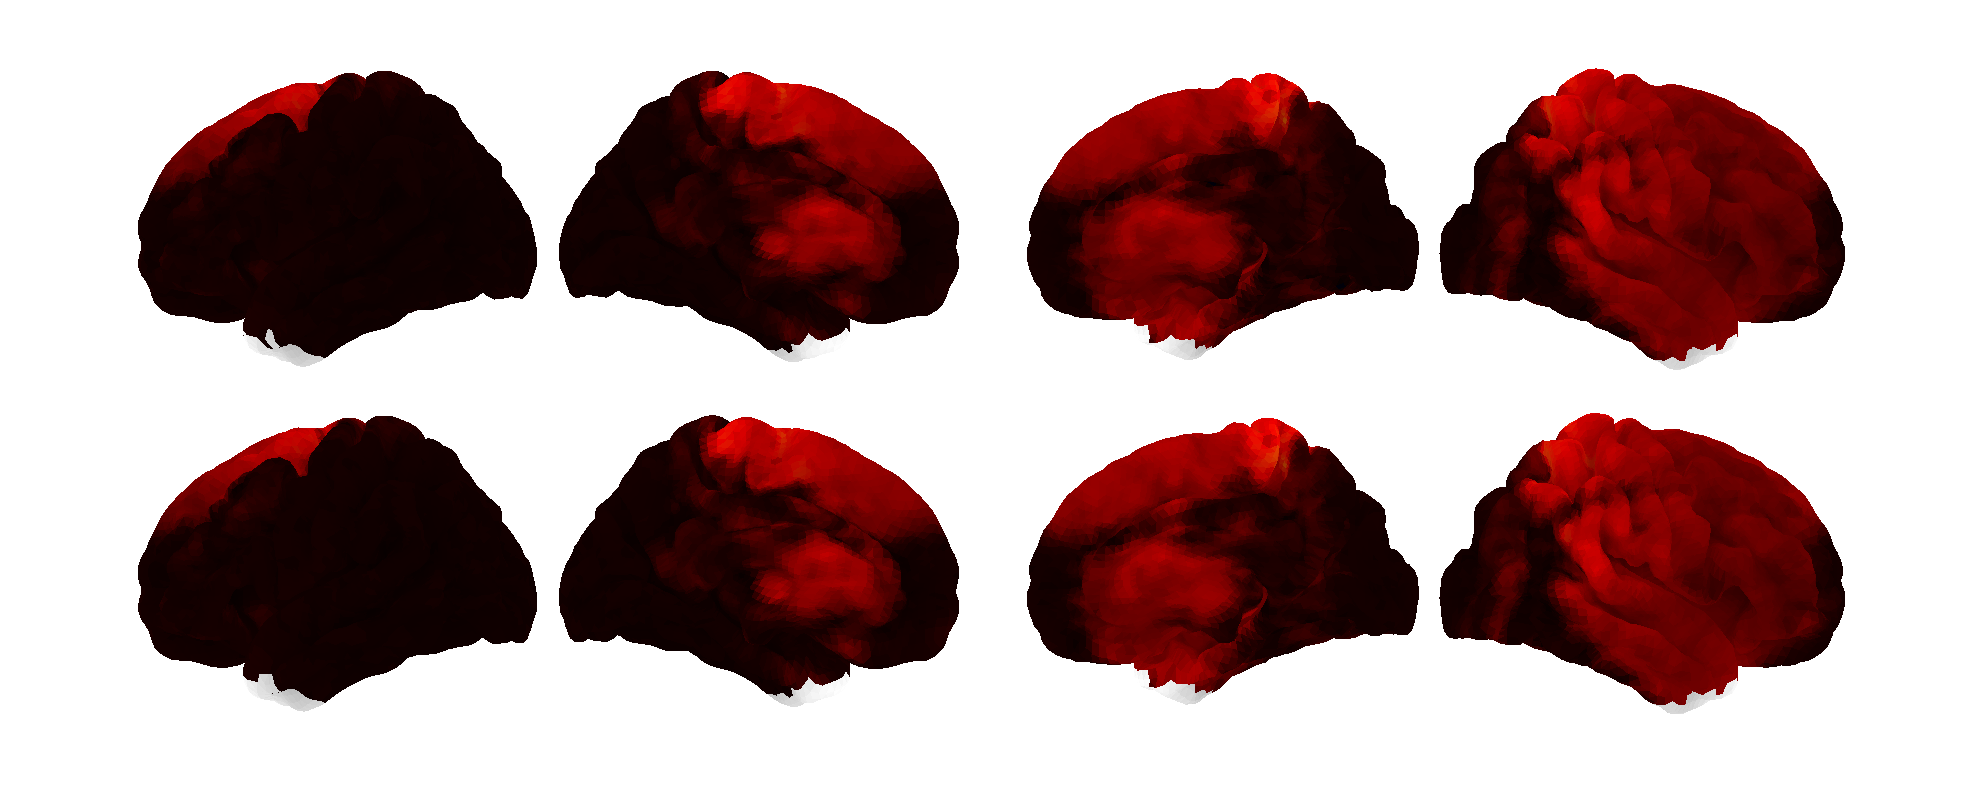

In [29]:
import numpy as np
import nibabel as nib
from nilearn import image
from src.plotting import pretty_plot

imgs = [image.index_img(nib.load(fmri_data[0]), 5), image.index_img(nib.load(fmri_data[0]), 100)]
vmax = np.max(imgs[0].get_fdata())

pretty_plot(
    imgs, 
    zmaps=None, 
    masks=None,
    names=['img-5', 'img-100'],
    ref_img=None,
    vmax=vmax, 
    cmap='cold_hot',
    saving_folder='../derivatives/', 
    plot_name='First_Image',
    row_size_factor=6,
    overlapping=6,
    column_size_factor=8,
    )

This data is volumic and include many point outside brain volume. You want to filter them out.

To do so you use a NiftiMasker object that transforms your NifitImage into a numpy array, keeping only voxels of interest (where there is enough signal).

In [2]:
from src.data import load_fmri_data, load_stmuli, fetch_masker, preprocess_fmri_data, preprocess_stimuli_data

# Fetch or create a masker object that retrieve the voxels of interest in the brain
masker = fetch_masker('./derivatives/masker', fmri_data, **{'detrend': True, 'standardize': True})

# Process fmri data with the masker
fmri_data = preprocess_fmri_data(fmri_data, masker)
stimuli_data = preprocess_stimuli_data(stimuli_data)

In [3]:
import nibabel as nib
import pandas as pd

print(f'There are {len(fmri_data)} files of fMRI data.')
print(f'Of sizes: {[i.shape for i in fmri_data]}')

print(f'There are {len(stimuli_data)} files of stimuli data.')
print(stimuli_data[0].head())

There are 2 files of fMRI data.
Of sizes: [(493, 194317), (450, 194317)]
There are 2 files of stimuli data.
    Onset  Offset       Word
0  0.0125  1.5425  everybody
1  1.5425  1.6925        shh
2  1.6925  2.3225        shh
3  2.3525  3.4025    central
4  3.4025  3.8325       perk


In [4]:
import numpy as np

# Extracting the offsets of the words: when do they appear in the stimuli ?
gentles = [s['Offset'].values for s in stimuli_data]

# To process the features extracted by the model (GloVe/GPT-2), we will need to know 
# how many rows there are for each file.
lengths = [len(f) for f in gentles]
start_stop = []
start = 0
for l in lengths:
    stop = start + l
    start_stop.append((start, stop))
    start = stop
groups = [np.arange(start, stop, 1) for (start, stop) in start_stop]

# Preparing fMRI data
nscans = [f.shape[0] for f in fmri_data] # number of scnas per session
Y = np.vstack(fmri_data)
Y.shape

(943, 194317)

## Extracting Features

### GloVe

In [7]:
import os, gdown

# Loading GloVe Model
trained_model = './data/glove.6B.300d.txt'
if not os.path.exists(trained_model):
    url = "https://nlp.stanford.edu/data/glove.6B.zip"
    output = './data/glove.zip'
    gdown.download(url, output, quiet=False)
    os.system(f'unzip {output} -d ./data/')


In [8]:
import pandas as pd
from tqdm import tqdm
from models import extract_glove_features

# Create the GloVe model which is a dictionary from the loaded file
glove_model = {}
with open(trained_model, 'r', encoding="utf-8") as f: 
    for line in tqdm(f): 
        values = line.split() 
        word = values[0] 
        vector = np.asarray(values[1:], "float32") 
        glove_model[word] = vector 

print(f"The vector associated with ‘the‘ has the size: {glove_model['the'].size}")


glove_model = extract_glove_features.update_model(glove_model, embedding_size=300)

features_glove = []
FEATURE_COUNT = 300 # glove representation are vectors of size 300
for s in stimuli_data:
    words = s['Word'].values
    features = []
    columns = ['embedding-{}'.format(i) for i in range(1, 1 + FEATURE_COUNT)]
    features = []
    for item in tqdm(words):
        if item not in glove_model.keys():
            print(item)
            item = '<unk>'
        features.append(glove_model[item])
    features = pd.DataFrame(np.vstack(features), columns=columns)
    features_glove.append(features)
print(features_glove[0].head())

400000it [00:21, 18860.43it/s]


The vector associated with ‘the‘ has the size: 300


100%|██████████| 2/2 [00:00<00:00, 134.42it/s]

   embedding-1  embedding-2  embedding-3  embedding-4  embedding-5  \
0     0.028774     0.091027      0.23404      0.10720    -0.067256   
1     1.125000    -0.476420      0.53420      0.44380    -0.262860   
2     1.125000    -0.476420      0.53420      0.44380    -0.262860   
3    -0.082372    -0.203110     -0.37970     -0.64093     0.315040   
4     0.234350     0.016208     -0.20724      0.14880     0.473860   

   embedding-6  embedding-7  embedding-8  embedding-9  embedding-10  ...  \
0     0.251000    -0.014845     0.065653      0.13384      -1.26780  ...   
1     0.908110    -0.349840    -0.439340     -0.11631      -0.29070  ...   
2     0.908110    -0.349840    -0.439340     -0.11631      -0.29070  ...   
3    -0.060771     0.082182     0.726650     -0.27680      -1.71890  ...   
4     0.155480     0.519830     0.261240     -0.09427       0.29063  ...   

   embedding-291  embedding-292  embedding-293  embedding-294  embedding-295  \
0        0.31578       -0.11004      -0.08

In [ ]:
## --> Do the entire stuff quickly <--
## Load the GloVe model
#from models import extract_glove_features
#gpt2_model, tokenizer = extract_glove_features.load_glove_model()
#
## Extracting features with GloVe
#features_glove = [
#    extract_glove_features.extract_features(
#        s['word'].values, 
#        glove_model, 
#        FEATURE_COUNT=768,
#        ) for s in stimuli_data
#    ] # list of pandas DataFrames
#

In [9]:
features_glove = [df.values for df in features_glove]
X_glove = np.vstack(features_glove) # shape: (#words_total * #features)
print(X_glove.shape)

### GPT-2

In [11]:
from models import extract_gpt2_features

# Loading GPT-2 Model
gpt2_model, tokenizer = extract_gpt2_features.load_model_and_tokenizer('gpt2')

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [13]:

words = stimuli_data[0]['Word'].values
sample_words = words[:100]
iterator = ' '.join(sample_words)

print('Example of stimuli sample given to the model:')
print(' '.join(sample_words))

tokenized_text = tokenizer.tokenize(iterator)
print(f'Tokenized text: {tokenized_text}')
mapping = extract_gpt2_features.match_tokenized_to_untokenized(tokenized_text, iterator)
print(f'We learn how a given word is separated into several tokens: {mapping}')


Example of stimuli sample given to the model:
everybody shh shh central perk is proud to present the music of miss phoebe buffay hi i want to start with a song that's about that moment when you suddenly realize what life is really all about okay here we go okay thank you very much what the oh great this is just wow this is so cool the entire city is blacked out mom says it's all of manhattan parts of brooklyn and queens and they have no idea when it's coming back on guys this is big pants and a sweater why mom who am i going to
Tokenized text: ['every', 'body', 'Ġsh', 'h', 'Ġsh', 'h', 'Ġcentral', 'Ġperk', 'Ġis', 'Ġproud', 'Ġto', 'Ġpresent', 'Ġthe', 'Ġmusic', 'Ġof', 'Ġmiss', 'Ġph', 'oe', 'be', 'Ġbuff', 'ay', 'Ġhi', 'Ġi', 'Ġwant', 'Ġto', 'Ġstart', 'Ġwith', 'Ġa', 'Ġsong', 'Ġthat', "'s", 'Ġabout', 'Ġthat', 'Ġmoment', 'Ġwhen', 'Ġyou', 'Ġsuddenly', 'Ġrealize', 'Ġwhat', 'Ġlife', 'Ġis', 'Ġreally', 'Ġall', 'Ġabout', 'Ġokay', 'Ġhere', 'Ġwe', 'Ġgo', 'Ġokay', 'Ġthank', 'Ġyou', 'Ġvery', 'Ġmuch', 'Ġ

In [14]:
context_size = 50    # number of tokens before each token for which we retrieve the embedding vector
max_seq_length = 512  # maximum input size that can be given to the model
space='Ġ'             # specific to the tokenizer...
special_token_beg='<|endoftext|>' # special tokens added at the beginning of the sentence specific to the tokenizer...
special_token_end='<|endoftext|>' # special tokens added at the end of the sentence specific to the tokenizer...


input_ids, indexes, tokens = extract_gpt2_features.batchify_to_truncated_input(
    iterator, tokenizer, 
    context_size=context_size, 
    max_seq_length=max_seq_length, 
    space=space, 
    special_token_beg=special_token_beg, 
    special_token_end=special_token_end)

print(input_ids)
print(input_ids.shape)
print()
print(indexes)

tensor([[50256, 16833,  2618,  ...,   845,   220, 50256],
        [50256,  2618,   427,  ...,   881,   220, 50256],
        [50256,   427,    71,  ...,   644,   220, 50256],
        ...,
        [50256, 28796,   428,  ...,  1016,   220, 50256],
        [50256,   428,   318,  ...,   284,   220, 50256],
        [50256,   318,   523,  ...,   220, 50256,   220]])
torch.Size([63, 55])

[(1, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 52), (51, 5

In [16]:
# Extracting features with GPT-2
features_gpt2 = [
    extract_gpt2_features.extract_features(
        s['Word'].values, 
        gpt2_model, 
        tokenizer,
        FEATURE_COUNT=768,
        NUM_HIDDEN_LAYERS=12,
        ) for s in stimuli_data
    ] # list of pandas DataFrames

features_gpt2 = [df.values for df in features_gpt2]
X_gpt2 = np.vstack(features_gpt2) # shape: (#words_total * #features)
print(X_gpt2.shape)


Token indices sequence length is longer than the specified maximum sequence length for this model (1352 > 1024). Running this sequence through the model will result in indexing errors
100%|██████████| 36/36 [05:23<00:00,  9.00s/it]


### Training the encoding model

In [17]:
from src.encoder import Encoder

fmri_ndim = None
features_ndim = 50
reduction_method = 'pca'
tr = 1.49
encoding_method = 'hrf'
linearmodel = 'ridgecv'

encoder = Encoder(
    linearmodel=linearmodel, 
    reduction_method=reduction_method, 
    fmri_ndim=fmri_ndim, 
    features_ndim=features_ndim, 
    encoding_method=encoding_method, 
    tr=tr
    )

/Applications/anaconda3/envs/parietal/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


In [19]:
Y.shape

(943, 194317)

In [23]:
from src.features import DesignMatrixBuilder

dm = DesignMatrixBuilder(
                    method=encoding_method,
                    tr=tr,
                    groups=groups,
                    gentles=gentles,
                    nscans=nscans,
                )

In [25]:
dm.fit_transform(X_glove).shape

(944, 300)

In [33]:
gentles

[array([  1.5425,   1.6925,   2.3225, ..., 734.0225, 734.1125, 734.1725]),
 array([1.025000e-01, 1.512500e+00, 1.682500e+00, ..., 6.705925e+02,
        6.706825e+02, 6.707725e+02])]

In [18]:

encoder.fit(X_glove, Y, groups=groups, gentles=gentles, nscans=nscans)
pred = encoder.predict(X_glove)
scores_glove = encoder.eval(pred, Y)



ValueError: Found input variables with inconsistent numbers of samples: [944, 943]

In [21]:

encoder.fit(X_gpt2, Y, groups=groups, gentles=gentles, nscans=nscans)
pred = encoder.predict(X_gpt2)
scores_gpt2 = encoder.eval(pred, Y)

ValueError: Found input variables with inconsistent numbers of samples: [944, 943]

In [ ]:

imgs = [masker.inverse_transform(scores_glove), masker.inverse_transform(scores_gpt2)]
zmaps = None
masks = None
names = ['GloVe', 'GPT-2']

pretty_plot(
    imgs, 
    zmaps, 
    masks,
    names,
    ref_img=None,
    vmax=0.2, 
    cmap='cold_hot',
    hemispheres=['left', 'right'], 
    views=['lateral', 'medial'], 
    categorical_values=False, 
    inflated=False, 
    saving_folder='../derivatives/', 
    format_figure='pdf', 
    dpi=300, 
    plot_name='test',
    row_size_factor=6,
    overlapping=6,
    column_size_factor=12,
    )
